In [2]:
# Φόρτωση βιβλιοθηκών και προετοιμασία περιβάλλοντος 

!pip install wget
!pip install tensorflow==2.10.0
!pip install transformers
!pip install seaborn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py", out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_, remove_digits, remove_special_characters, removeStopWords, remove_links, punct, email_address, lower, non_ascii
from collections import  Counter
from transformers import AutoTokenizer, TFAutoModel

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2cdde3e8dfd270838ba216a0596fef36175e6fc1ad71dc5854d501a1dab81eda
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 77.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall:

2025-05-26 12:53:12.541858: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Φόρτωση δεδομένων 
df = pd.read_csv("/kaggle/input/symptom2disease/Symptom2Disease.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# Εξερεύνηση δεδομένων
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())
print(df.isna().sum())
print(df.duplicated().sum())

       label                                               text
0  Psoriasis  I have been experiencing a skin rash on my arm...
1  Psoriasis  My skin has been peeling, especially on my kne...
2  Psoriasis  I have been experiencing joint pain in my fing...
3  Psoriasis  There is a silver like dusting on my skin, esp...
4  Psoriasis  My nails have small dents or pits in them, and...
(1200, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1200 non-null   object
 1   text    1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB
None
            label                                               text
count        1200                                               1200
unique         24                                               1153
top     Psoriasis  I've been feeling extremely scratchy, sick, an...
freq           50                 

In [5]:
df = df.drop_duplicates()
df.shape

(1153, 2)

In [6]:
# Προσθήκη αριθμού λέξεων
df['num_words'] = df.text.apply(len)
print(df.num_words.describe())

count    1153.000000
mean      171.112749
std        35.500946
min        60.000000
25%       147.000000
50%       169.000000
75%       192.000000
max       317.000000
Name: num_words, dtype: float64


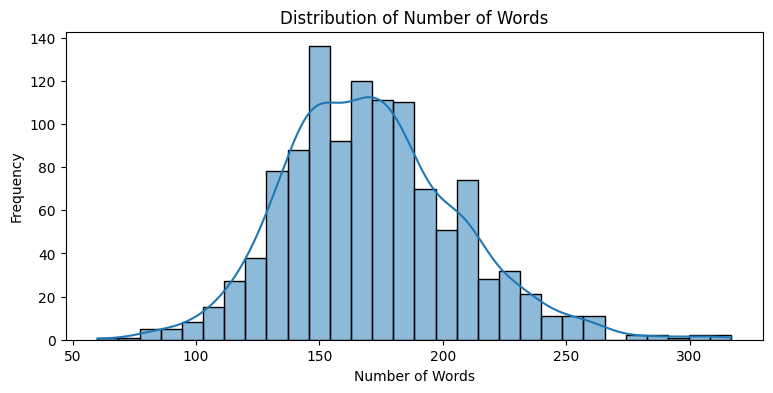

In [7]:
# Οπτικοποίηση κατανομής αριθμού λέξεων μέσα στο Dataset
plt.figure(figsize=(9, 4))
fig = sns.histplot(df['num_words'], kde=True) 
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words')
plt.show()

In [8]:
# Ορισμός μέγιστου μήκους εισόδου
max_len = 320

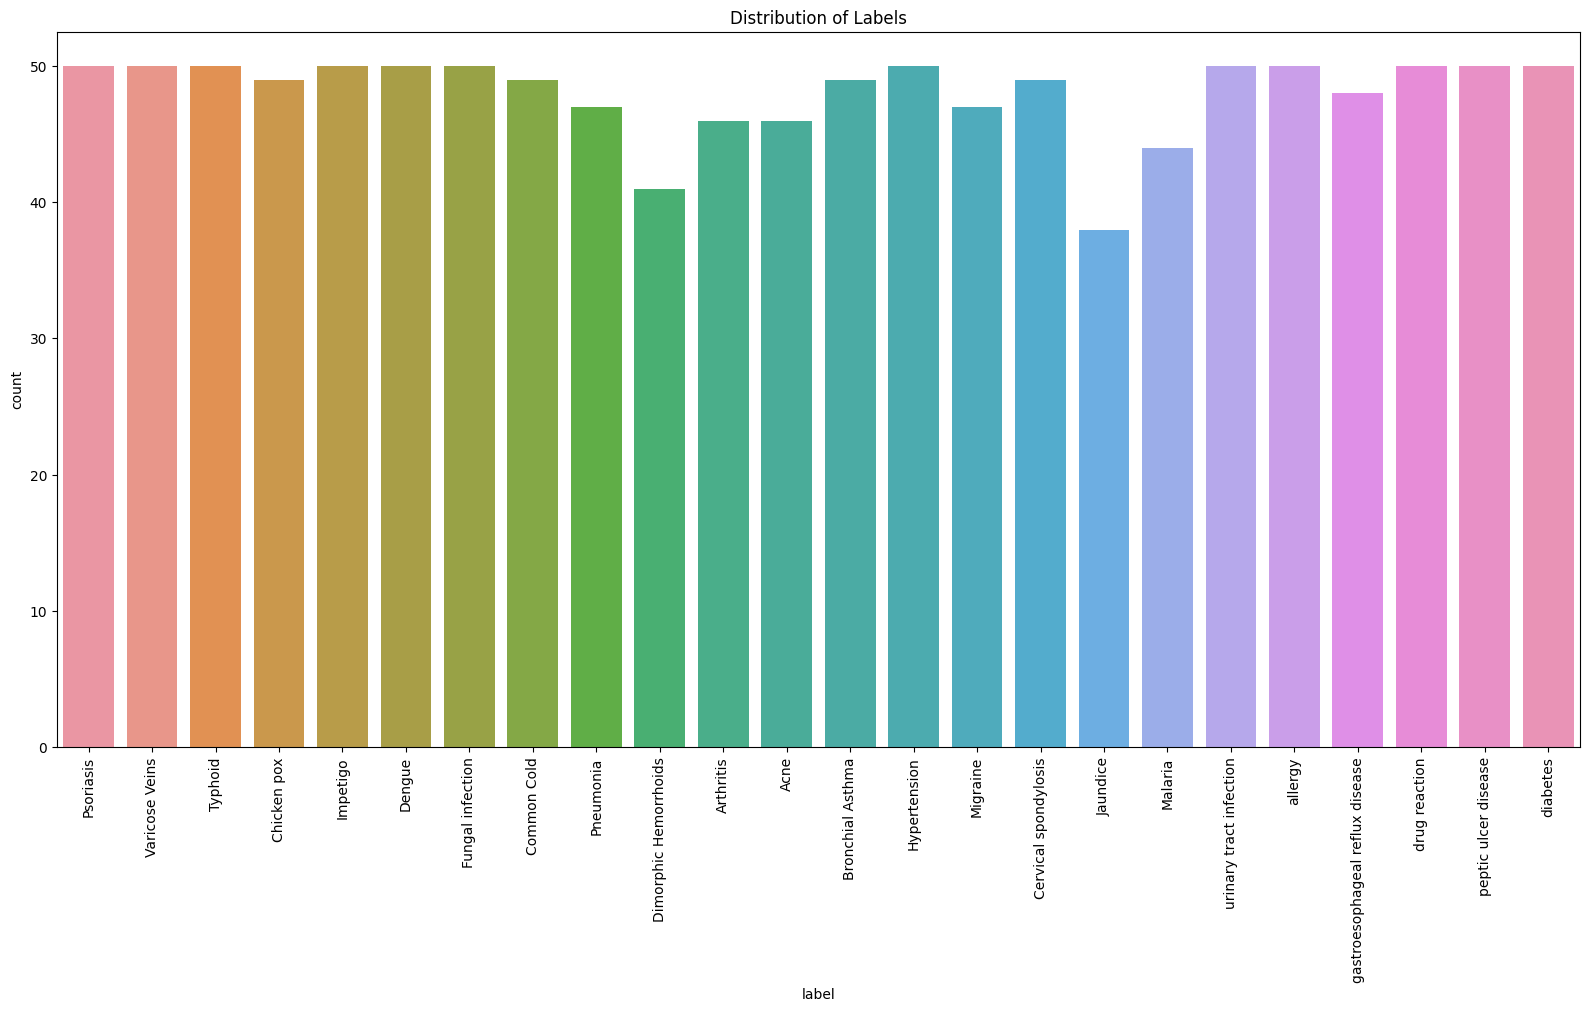

In [9]:
# Οπτικοποίηση κατανομής των label
plt.figure(figsize=(16, 10))
fig = sns.countplot(x='label', data=df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Distribution of Labels')
plt.show()

[('and', 2470), ('I', 1480), ('my', 1212), ('a', 1196), ('been', 1018), ('have', 1005), ("I've", 618), ('My', 570), ('of', 524), ('to', 498)]
Top 25 most frequently occurring words 


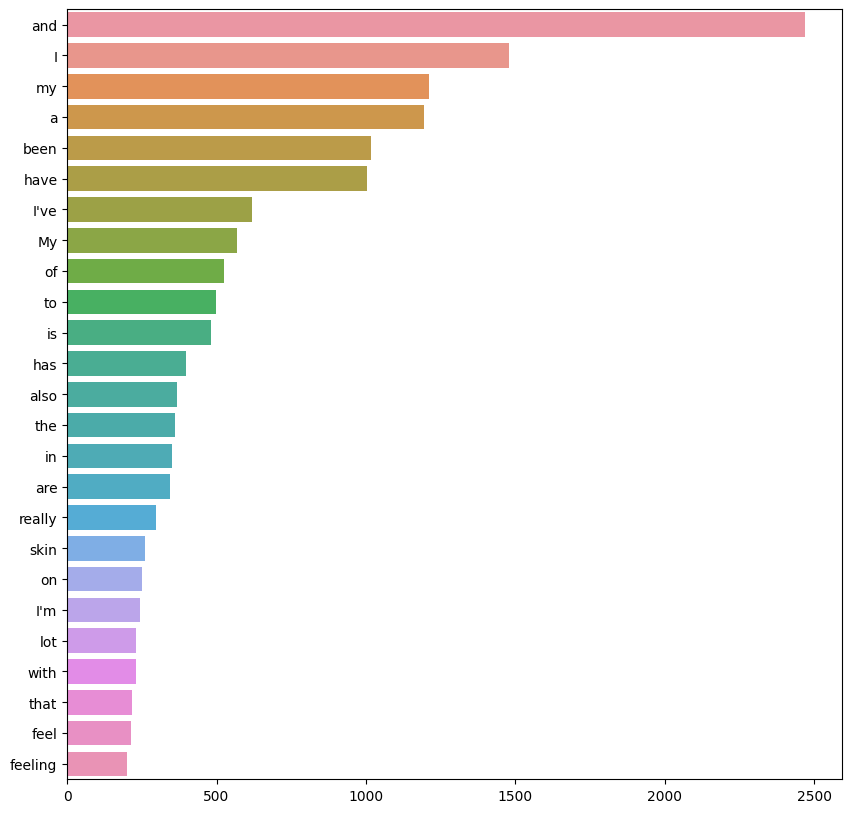

In [10]:
#Οπτικοποίηση των 25 πιο συχνά εμφανιζόμενων λέξεων μέσα στο Dataset πριν τον καθαρισμό των κειμένων 
corpus = []
for x in df['text'].str.split():
    corpus.extend(x)
counter=Counter(corpus)
most=counter.most_common()
print(most[0:10])

first_n = 25
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print("Top "  f"{first_n} most frequently occurring words ")

In [11]:
# Συνάρτηση καθαρισμού κειμένου
def clean_text(data, col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [14]:
# Εφαρμογή της συνάρτησης καθαρισμού κειμένου και προβολή των δεδομένων
preprocessed_df = clean_text(df, 'text')
preprocessed_df.drop(columns='num_words', inplace=True)
print(preprocessed_df.head())
print(preprocessed_df.columns)

       label                                               text
0  Psoriasis  experiencing skin rash arms legs torso past we...
1  Psoriasis  skin peeling especially knees elbows scalp pee...
2  Psoriasis  experiencing joint pain fingers wrists knees p...
3  Psoriasis  silver dusting skin especially lower back scal...
4  Psoriasis  ails small dents pits often feel inflammatory ...
Index(['label', 'text'], dtype='object')


[('also', 392), ('skin', 349), ('lot', 313), ('really', 300), ('pain', 256), ('fever', 230), ('feel', 214), ('feeling', 202), ('experiencing', 189), ('high', 188)]
Top 25 most frequently occurring words after text cleaning 


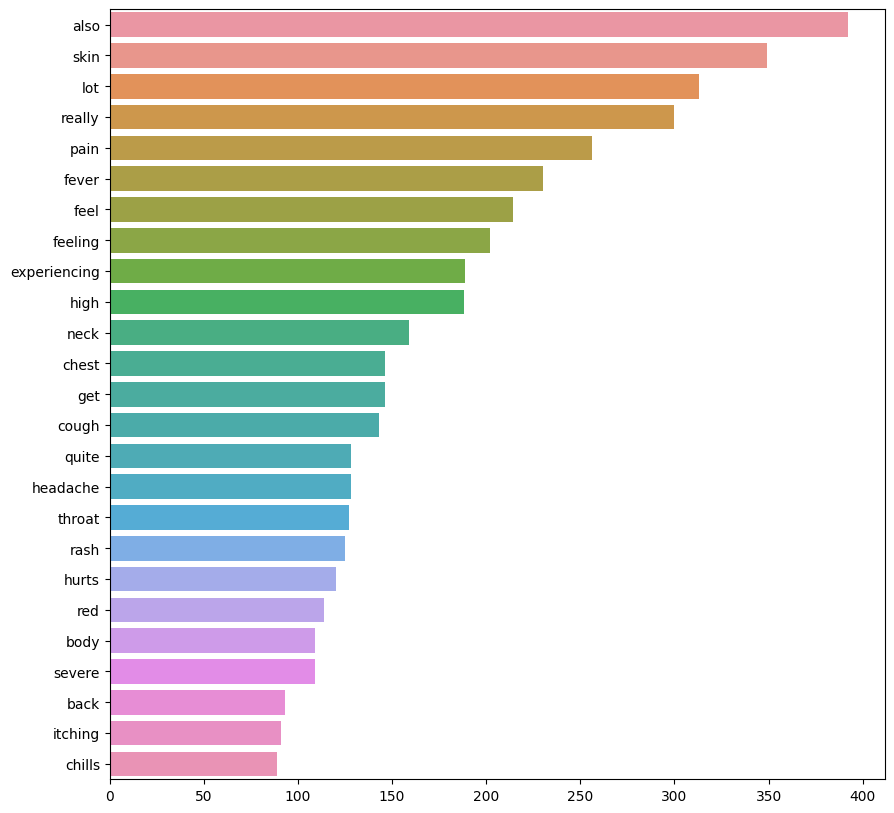

In [15]:
#Οπτικοποίηση των 25 πιο συχνά εμφανιζόμενων λέξεων μέσα στο Dataset μετά τον καθαρισμό των κειμένων
corpus2 = []
for x in preprocessed_df['text'].str.split():
    corpus2.extend(x)
counter2=Counter(corpus2)
most2=counter2.most_common()
print(most2[0:10])

x, y= [], []
for word2,count2 in most2[:first_n]:
        x.append(word2)
        y.append(count2)
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print("Top "  f"{first_n} most frequently occurring words after text cleaning ") 

In [16]:
# Εφαρμογή one-hot encoding στις ετικέτες

one_hot_labels = preprocessed_df['label'].str.get_dummies()
preprocessed_df = pd.concat([preprocessed_df, one_hot_labels], axis=1)
print(preprocessed_df.head())

       label                                               text  Acne  \
0  Psoriasis  experiencing skin rash arms legs torso past we...     0   
1  Psoriasis  skin peeling especially knees elbows scalp pee...     0   
2  Psoriasis  experiencing joint pain fingers wrists knees p...     0   
3  Psoriasis  silver dusting skin especially lower back scal...     0   
4  Psoriasis  ails small dents pits often feel inflammatory ...     0   

   Arthritis  Bronchial Asthma  Cervical spondylosis  Chicken pox  \
0          0                 0                     0            0   
1          0                 0                     0            0   
2          0                 0                     0            0   
3          0                 0                     0            0   
4          0                 0                     0            0   

   Common Cold  Dengue  Dimorphic Hemorrhoids  ...  Pneumonia  Psoriasis  \
0            0       0                      0  ...          0         

In [17]:
# Εύρεση των μοναδικών ετικετών και δημιουργία ενός λεξικού για αναφορά
label_columns = preprocessed_df['label'].unique().tolist()
print(label_columns)

['Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken pox', 'Impetigo', 'Dengue', 'Fungal infection', 'Common Cold', 'Pneumonia', 'Dimorphic Hemorrhoids', 'Arthritis', 'Acne', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Cervical spondylosis', 'Jaundice', 'Malaria', 'urinary tract infection', 'allergy', 'gastroesophageal reflux disease', 'drug reaction', 'peptic ulcer disease', 'diabetes']


In [18]:
# Διαχωρισμός δεδομένων σε train - test 
train_df, test_df = train_test_split(preprocessed_df, test_size=0.3, stratify=preprocessed_df.label, shuffle=True, random_state=101)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')  # Χρήση του RoBERTa tokenizer
roberta_model = TFAutoModel.from_pretrained('roberta-base')  # Χρήση του RoBERTa μοντέλου

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [21]:
# Επεξεργασία των δεδομένων εισόδου
X_train = tokenizer(
    text=train_df.text.tolist(),
    max_length=max_len,
    padding='max_length',
    truncation=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='tf',
    return_token_type_ids=False,
    verbose=1
)

X_test = tokenizer(
    text=test_df.text.tolist(),
    max_length=max_len,
    padding='max_length',
    truncation=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='tf',
    return_token_type_ids=False,
    verbose=1
)

In [22]:
# Προετοιμασία των labels για εκπαίδευση και δοκιμή με χρήση one-hot encoding
y_train = train_df[label_columns].values
y_test = test_df[label_columns].values

In [23]:
# Ορισμός εισόδου του μοντέλου
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

In [24]:
# Χρήση του RoBERTa μοντέλου για την παραγωγή embeddings
outputs = roberta_model(input_ids, attention_mask=attention_mask)  # Χρήση του RoBERTa output για το τελευταίο hidden state
embeddings = outputs.last_hidden_state

In [25]:
# Προσθήκη επιπλέον πυκνών στρωμάτων και batch normalization
output = Flatten()(embeddings)
output = Dense(units=128, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=64, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.1)(output)
output = Dense(units=32, activation='relu')(output)
output = Dense(units=len(label_columns), activation='softmax')(output)

In [26]:
# Δημιουργία του τελικού μοντέλου
model = Model(inputs=[input_ids, attention_mask], outputs=output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 320)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 320)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 320,                                           

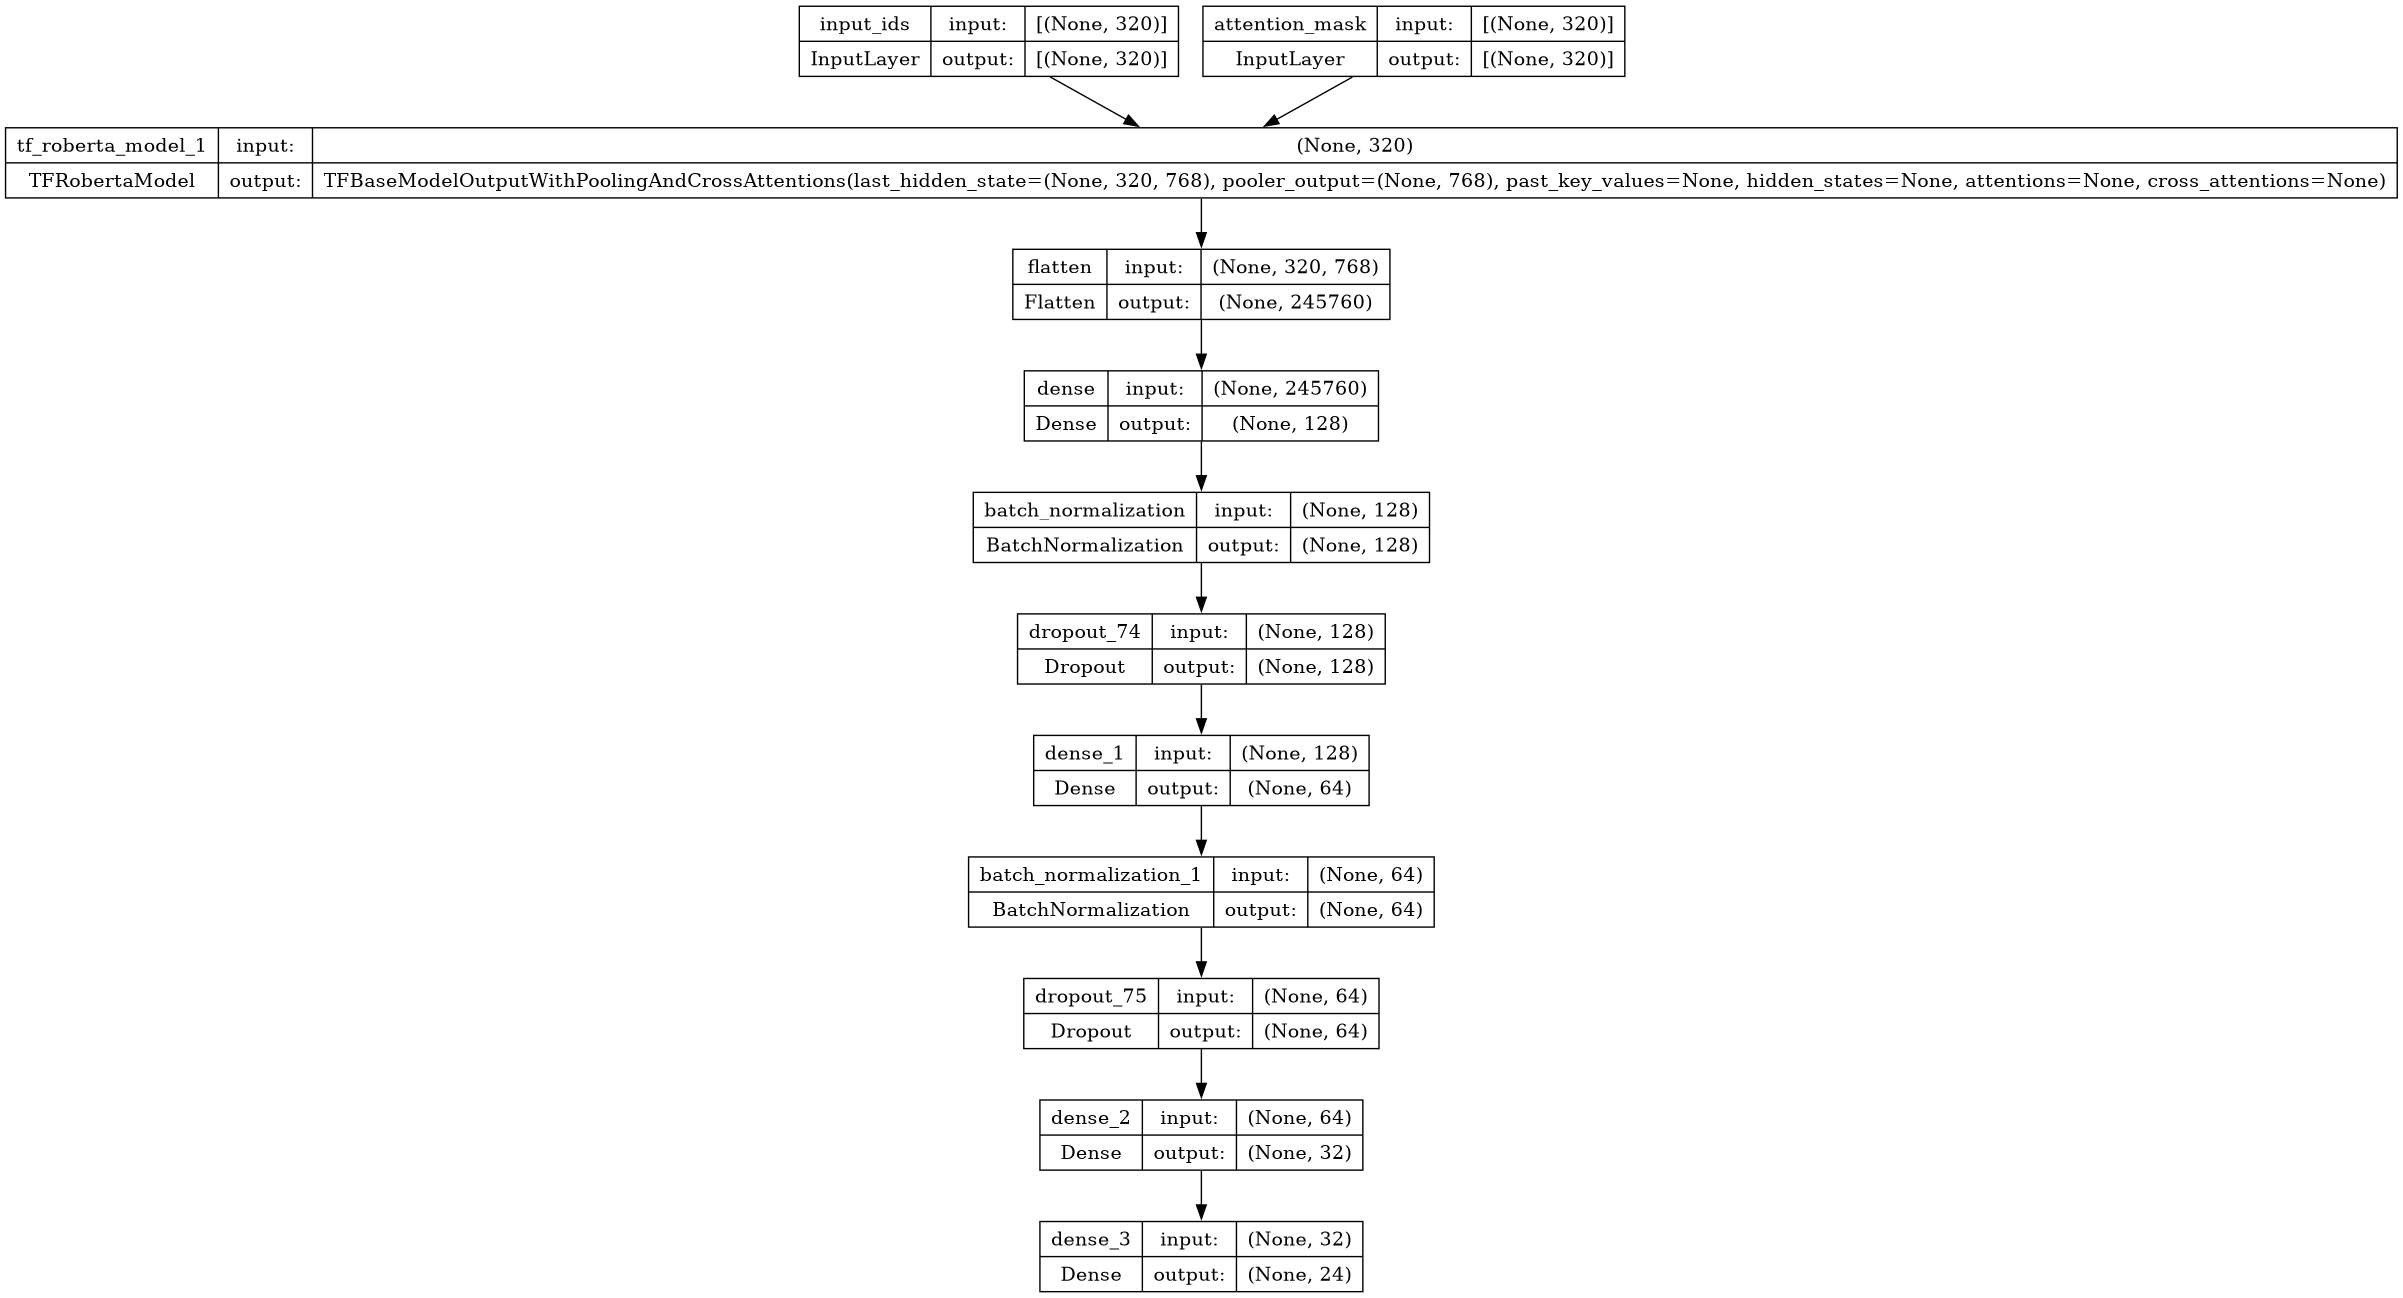

In [27]:
# Καθορισμός των παραμέτρων εκπαίδευσης του μοντέλου
model.layers[2].trainable = True
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, dpi=100)

In [28]:
# Ορισμός του optimizer και της συνάρτησης απώλειας
adam = Adam(learning_rate=5e-5, epsilon=2e-7, decay=1e-2, clipnorm=1.0)
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=adam, metrics=[CategoricalAccuracy('balanced_accuracy')])

In [29]:
# Συνάρτηση μείωσης του learning rate με το χρόνο
def time_based_decay(epoch, lr):
    decay_rate = 1e-5
    decay_epoch = 10
    return lr * (1 / (1 + decay_rate * epoch / decay_epoch))

In [30]:
# Ορισμός callbacks για την εκπαίδευση του μοντέλου
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
lr_scheduler = LearningRateScheduler(schedule=time_based_decay, verbose=1)
mc = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [31]:
# Εκπαίδευση του μοντέλου
history = model.fit(
    x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y=y_train,
    validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[es, lr_scheduler, mc]
)


Epoch 1: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 2.8587 - balanced_accuracy: 0.1487 
Epoch 1: val_loss improved from inf to 2.71737, saving model to best_model.h5
51/51 [==============================] - 2111s 41s/step - loss: 2.8587 - balanced_accuracy: 0.1487 - val_loss: 2.7174 - val_balanced_accuracy: 0.1965 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.9999948736945024e-05.
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.9946 - balanced_accuracy: 0.4820 
Epoch 2: val_loss improved from 2.71737 to 2.25303, saving model to best_model.h5
51/51 [==============================] - 2097s 41s/step - loss: 1.9946 - balanced_accuracy: 0.4820 - val_loss: 2.2530 - val_balanced_accuracy: 0.3353 - lr: 5.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.999984780549485e-05.
Epoch 3/10
51/51 [==============================] - ETA: 

In [32]:
# Αξιολόγηση του μοντέλου
evaluation = model.evaluate(
    x={'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},
    y=y_test
)
print(f"Evaluation: {evaluation}")

11/11 [==============================] - 252s 23s/step - loss: 0.5558 - balanced_accuracy: 0.9335
Evaluation: [0.5557749271392822, 0.9335260391235352]


11/11 [==============================] - 246s 22s/step


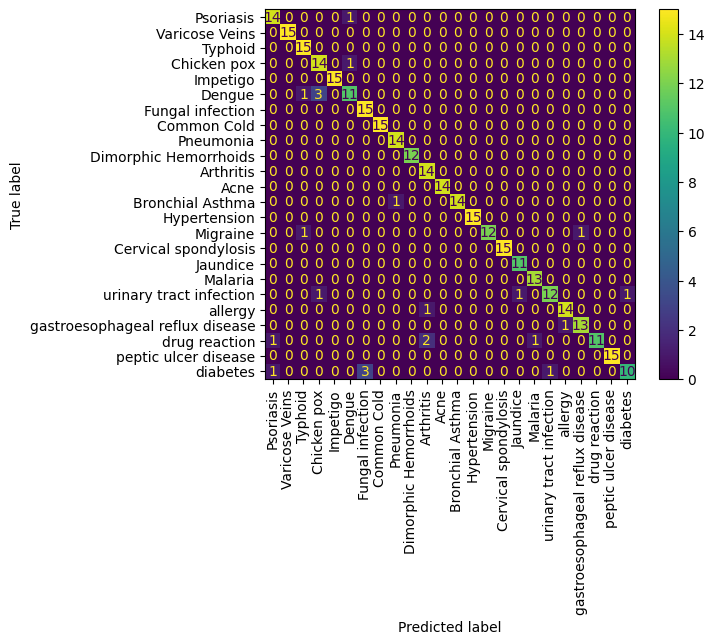

                                 precision    recall  f1-score   support

                      Psoriasis       0.88      0.93      0.90        15
                 Varicose Veins       1.00      1.00      1.00        15
                        Typhoid       0.88      1.00      0.94        15
                    Chicken pox       0.78      0.93      0.85        15
                       Impetigo       1.00      1.00      1.00        15
                         Dengue       0.85      0.73      0.79        15
               Fungal infection       0.83      1.00      0.91        15
                    Common Cold       1.00      1.00      1.00        15
                      Pneumonia       0.93      1.00      0.97        14
          Dimorphic Hemorrhoids       1.00      1.00      1.00        12
                      Arthritis       0.82      1.00      0.90        14
                           Acne       1.00      1.00      1.00        14
               Bronchial Asthma       1.00      0.

In [33]:
# Δημιουργία confusion matrix και classification report
y_pred_probs = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_columns).plot(xticks_rotation='vertical')
plt.show()

print(classification_report(y_true, y_pred, target_names=label_columns))

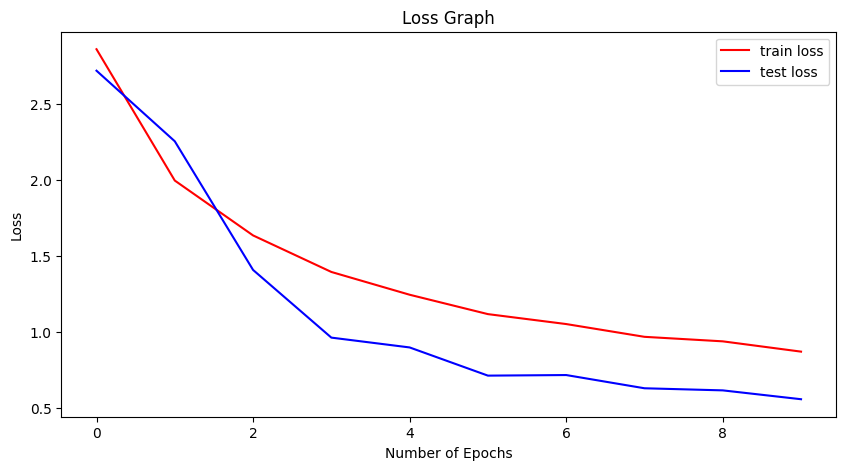

In [36]:
#Δημιουργία του Loss Graph
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

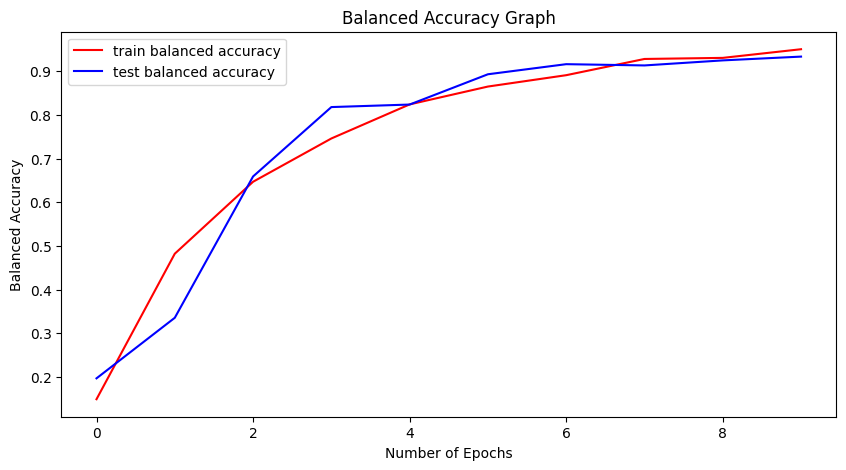

In [37]:
#Δημιουργία του Balanced Accuracy Graph
plt.figure(figsize=(10,5))
plt.plot(history.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(history.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

In [44]:
#Δοκιμή του μοντέλου RoBERTa
input_text = "I've been experiencing chills, fever, and extreme stomach discomfort. I am unhappy, and can't seem to get rid of these symptoms."

def preprocess_text(text, max_length):
    # Tokenize the input text
    inputs = tokenizer(text, 
                       max_length=max_length,
                       padding='max_length', 
                       truncation=True,  
                       return_tensors="tf",
                       return_attention_mask=True,
                       return_token_type_ids=False,
                       add_special_tokens=True,
                       verbose=1)
    return inputs

inputs = preprocess_text(input_text,max_len)
predictions = model.predict([inputs['input_ids'], inputs['attention_mask']])
predictions = np.argmax(predictions,axis=1)[0]
print("Predicted Label:",label_columns[predictions])

1/1 [==============================] - 1s 740ms/step
Predicted Label: Typhoid
